# Visual Inspection of Motorcycle Connecting Rods

Students should develop a software system aimed at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

## Libraries and Data loading

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

import sys

sys.path.append(".")

data_folder = Path("ispezione-bielle-immagini")
task1_names = [
    "TESI00.BMP",
    "TESI01.BMP",
    "TESI12.BMP",
    "TESI21.BMP",
    "TESI31.BMP",
    "TESI33.BMP",
]

task2_names = [
    "TESI44.BMP",
    "TESI47.BMP",
    "TESI48.BMP",
    "TESI49.BMP",
    "TESI50.BMP",
    "TESI51.BMP",
    "TESI90.BMP",
    "TESI92.BMP",
    "TESI98.BMP",
]

paths_1 = []
paths_2 = []
for _path in data_folder.rglob("*.BMP"):
    if _path.name.upper() in task1_names:
        paths_1.append(_path)
    elif _path.name.upper() in task2_names:
        paths_2.append(_path)

# Load the images
images_1 = [cv2.imread(str(_path), cv2.IMREAD_GRAYSCALE) for _path in paths_1]
images_2 = [cv2.imread(str(_path), cv2.IMREAD_GRAYSCALE) for _path in paths_2]

# Print the images in a grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, (img, path) in enumerate(zip(images_1, paths_1)):
    axs[i // 3, i % 3].imshow(img, cmap="gray")
    axs[i // 3, i % 3].set_title(path.name)
    axs[i // 3, i % 3].axis("off")
plt.show()

<Figure size 1500x1000 with 6 Axes>

## First task

**Image characteristics**
1. Images contain only connecting rods, which can be of both types and feature significantly diverse dimensions.
2. Connecting rods have been carefully placed within the inspection area so to appear well separated in images (i.e. they do not have any contact point).
3. Images have been taken by the backlighting technique so to render rods easily distinguishable (i.e. much darker) from background. However, for flexibility reasons the system should not
require any change to work properly with lighting sources of different power.

**Functional specifications**
For each connecting rod appearing in the image, the vision system should provide the following information:
1. Type of rod (A or B).
2. Position and orientation (modulo $\pi$).
3. Length, width and width at the barycenter.
4. For each hole, position of the centre and diameter size.

***

### Rod-type Detection

**Objectives**: detect the rods, detect the holes in each rod

The algorithm first preprocesses the image by applying a Gaussian filter (given $\sigma$, we set the kernel size to be equal to $\lceil (3 \sigma)^2 + 1 \rceil$.) and thresholding the image to create a binary image (we exploit the OpenCV method `cv2.threshold(img, thresh, maxval, type=cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)`). It then uses the `cv2.connectedComponentsWithStats()` function to find the connected components in the binary image. Each connected component corresponds to a rod in the image.

For each rod, the algorithm extracts the connected component and calculates its area, centroid, and number of holes. It then classifies the rod as either "Type A" (one hole) or "Type B" (two holes) based on the number of holes. Finally, it plots the connected component and displays the rod type.

The algorithm uses the OpenCV library to perform the image processing and blob detection. Blob detection is a technique for detecting regions in an image that share common properties, such as color or texture. In this case, the algorithm uses blob detection to detect the rods in the image. The algorithm then analyzes each rod to count the number of holes and classify the rod type. 

The algorithm is useful for applications such as quality control in manufacturing, where it is important to detect defects in products. By detecting the number of holes in each rod, the algorithm can identify defective rods that do not meet the required specifications.



Gaussian filter parameters --- sigma: 0.5, kernel size: 5
Number of rods found (CC): 3
Processing connected components individually...

Processing rod 1...
Rod 1: area (CC): 3241
Rod 1: number of holes: 1
Rod 1: type: A
Rod 1: length (MER): 169.35345458984375
Rod 1: width (MER): 39.77633285522461
Rod 1: mass center(s): [(198, 113)]
Rod 1: angle (mod pi): 1.976969182254725
Rod 1: width at mass center: 14.7648230602334


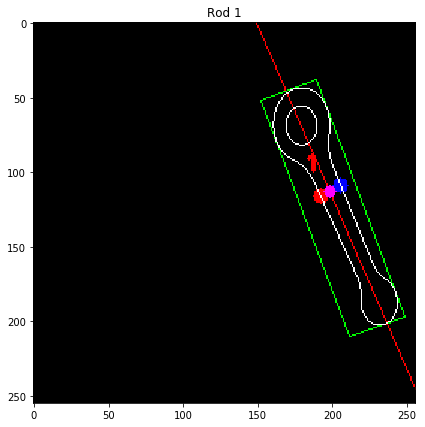

--------------------------------------------------
Processing rod 2...
Rod 2: area (CC): 1485
Rod 2: number of holes: 2
Rod 2: type: B
Rod 2: length (MER): 131.63897705078125
Rod 2: width (MER): 26.889116287231445
Rod 2: mass center(s): [(115, 115)]
Rod 2: angle (mod pi): 1.4577884183408638
Rod 2: width at mass center: 12.649110640673518


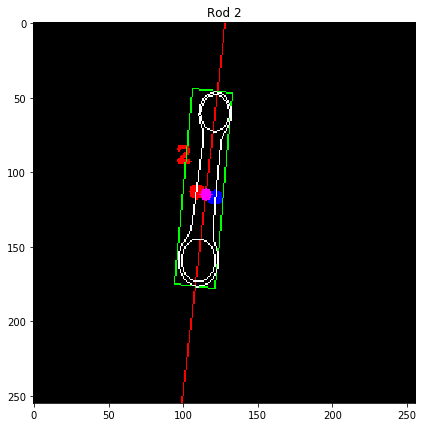

--------------------------------------------------
Processing rod 3...
Rod 3: area (CC): 3263
Rod 3: number of holes: 1
Rod 3: type: A
Rod 3: length (MER): 177.26246643066406
Rod 3: width (MER): 37.273799896240234
Rod 3: mass center(s): [(54, 148)]
Rod 3: angle (mod pi): 1.5013820814180452
Rod 3: width at mass center: 14.0


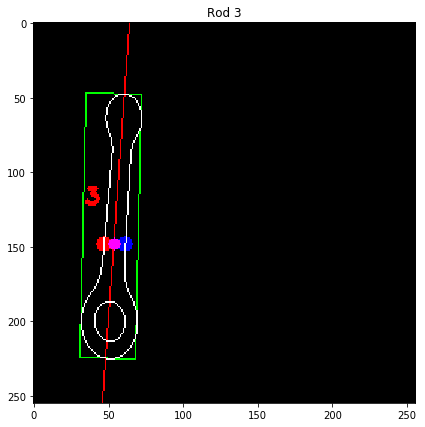

--------------------------------------------------


In [21]:
from src.rod_detection import detect_rods_blob, detect_rods

# Detects the rods for a single image, it outputs the various steps
rod_info = detect_rods_blob(images_1[0])
# print(rod_info)

In [223]:

# Draw the points
output = cv2.cvtColor(contour_img, cv2.COLOR_GRAY2RGB)

cv2.drawContours(output, ext_contours, -1, (0, 255, 0), 1)
cv2.circle(output, tuple(p_left), 5, (255, 0, 0), -1)       # red
cv2.circle(output, tuple(p_right), 5, (0, 0, 255), -1)      # blue
cv2.circle(output, tuple(mc), 5, (0, 255, 0), -1)           # green

# Given a,b,c draw the line ax + by + c = 0
def draw_line(a, b, c, img, color=(255, 255, 255)):
    if b == 0:
        cv2.line(img, (0, int(-c / a)), (img.shape[1], int(-c / a)), color, 2)
    else:
        cv2.line(
            img,
            (0, int(-c / b)),
            (img.shape[1], int((-a * img.shape[1] - c) / b)),
            color,
            2,
        )

draw_line(a, b, c, output, (255, 0, 0))

### Rod specific properties computation

**Objectives**: find the position, find the orientation (modulo $\pi$)

1. Since each rod is recognized by a connected component (CC) we can safely say that the position of the rod with respect to the image can be expressed by the CC's centroid coordinates $<x, y>$.
2. 